# Weakly-Supervised Segmentation Using Grad-Based Explaining Algorithms

Experiments on segmentation using SmoothGrad, Full-Gradients and Grad-CAM.

## References

- Srinivas, Suraj, and François Fleuret. "Full-gradient representation for neural network visualization." arXiv preprint arXiv:1905.00780 (2019). https://arxiv.org/abs/1905.00780
- Smilkov, Daniel, Nikhil Thorat, Been Kim, Fernanda Viégas, and Martin Wattenberg. "Smoothgrad: removing noise by adding noise." arXiv preprint arXiv:1706.03825 (2017). https://arxiv.org/pdf/1706.03825.pdf
- Selvaraju, Ramprasaath R., Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, and Dhruv Batra. "Grad-cam: Visual explanations from deep networks via gradient-based localization." In Proceedings of the IEEE international conference on computer vision, pp. 618-626. 2017. https://arxiv.org/abs/1610.02391

In [ ]:
import tensorflow as tf

LAST_SPACIAL_LAYER = 'top_activation'

REPETITIONS = tf.constant(20)
NOISE = tf.constant(0.2 * 255)

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

! cp -r '/content/drive/MyDrive/Colab Notebooks/cs-no/6.grads/config' .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from config import config, data, model, utils

from config.utils import to_image, normalize, standardize

utils.setup_clean_image_plotting()

In [ ]:
from tensorflow.python.keras.applications import efficientnet

config.model.architecture = tf.keras.applications.EfficientNetB3
config.model.module = efficientnet
config.model.decode = tf.keras.applications.efficientnet.decode_predictions
config.model.preprocess = tf.keras.applications.efficientnet.preprocess_input
config.model.decompress = lambda x: x

config.data.image_size = (300, 300)
config.data.input_shape = (config.data.batch_size, 300, 300, 3)

In [ ]:
from skimage import color

C = utils.plt.get_cmap('tab10').colors

def plot_segmentation_maps(i, seg):
    result_image = color.label2rgb(seg.numpy(), to_image(i), bg_label=0, bg_color=None, colors=C)
    utils.plt.imshow(result_image)
    utils.plt.axis('off');

In [ ]:
images = data.load_images()
x = model.preprocess(images)

In [ ]:
nn = model.build()

logits = nn(x, training=False)
preds = tf.argsort(logits, direction='DESCENDING')
probs = tf.nn.softmax(logits)
decoded = model.decode(probs.numpy(), top=5)

In [ ]:
nn_s = tf.keras.Model(
    inputs=nn.inputs,
    outputs=[nn.output, nn.get_layer(LAST_SPACIAL_LAYER).output],
    name='model_spacial')

In [ ]:
utils.plot(to_image(images), titles=[f'{e[0][1]} {e[0][2]:.0%}'  for e in decoded], rows=4);

## SmoothGrad

In [ ]:
def activation_loss(y, units):
    return tf.gather(y, units, axis=1, batch_dims=1)

@tf.function
def gradcam(inputs, units):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(inputs)
        y, z = nn_s(inputs, training=False)
        loss = activation_loss(y, units)

    dldx, grads = tape.gradient(loss, [inputs, z], unconnected_gradients=tf.UnconnectedGradients.ZERO)
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    maps = tf.reduce_mean(z*weights, axis=-1, keepdims=True)

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, dldx, maps

@tf.function
def smooth_gradients(inputs, units, num_samples=20, noise=.2):
    print(inputs.shape, units.shape)

    x = tf.repeat(inputs, num_samples, axis=0)
    x += tf.random.normal(tf.shape(x), mean=0, stddev=noise/2)
    
    y = tf.repeat(units, num_samples)
    loss, grads, maps = gradcam(x, y)

    grads = tf.reshape(grads, (-1, num_samples, *grads.shape[1:]))
    maps = tf.reshape(maps, (-1, num_samples, *maps.shape[1:]))

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.reduce_mean(maps, axis=1)

    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, tf.reduce_mean(grads, axis=1), maps

# One image at a time to avoid performance issues with larger models.
r = [smooth_gradients(x[i:i+1], preds[i:i+1, 0],
                      REPETITIONS,
                      NOISE)
     for i in range(len(images))]

loss, grads, maps = (tf.concat(t, axis=0) for t in zip(*r))

# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

(1, 300, 300, 3) (1,)


In [ ]:
#@title

utils.plot_heatmaps(to_image(images[:8]), maps[:8, ..., 0].numpy())
utils.plot(gs[:8, ..., 0].numpy())
utils.plot(gm[:8, ..., 0].numpy())

In [ ]:
#@title

utils.plot_heatmaps(to_image(images[8:]), maps[8:, ..., 0].numpy())
utils.plot(gs[8:, ..., 0].numpy())
utils.plot(gm[8:, ..., 0].numpy())

## Min-Max Activation

In [ ]:
def gather_sum(y, units):
    return tf.reduce_sum(tf.gather(y, units, axis=1, batch_dims=1), axis=-1)

def min_max_activation_gain(y, positive, negative):
    return gather_sum(y, positive) - gather_sum(y, negative)

@tf.function
def gradcam(inputs, positive, negative):
    with tf.GradientTape(watch_accessed_variables=False) as t:
        t.watch(inputs)
        y, z = nn_s(inputs, training=False)
        loss = min_max_activation_gain(y, positive, negative)

    dldx, grads = t.gradient(loss, [inputs, z])
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    maps = tf.reduce_mean(z*weights, axis=-1, keepdims=True)

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, dldx, maps

@tf.function
def smooth_gradients(inputs, positive, negative, num_samples=20, noise=.2):
    x = tf.repeat(inputs, num_samples, axis=0)
    x += tf.random.normal(tf.shape(x), mean=0, stddev=noise/2)
    
    positive = tf.repeat(positive, num_samples, axis=0)
    negative = tf.repeat(negative, num_samples, axis=0)
    loss, grads, maps = gradcam(x, positive, negative)

    grads = tf.reshape(grads, (-1, num_samples, *grads.shape[1:]))
    maps = tf.reshape(maps, (-1, num_samples, *maps.shape[1:]))

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.reduce_mean(maps, axis=1)

    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, tf.reduce_mean(grads, axis=1), maps

In [ ]:
SAMPLES = [x[7], x[7]]

POSITIVE = tf.constant([[652, 465],
                        [413, 764]])
NEGATIVE = tf.constant([[413, 764],
                        [652, 465]])

SEGMENTS = ['military_uniform', 'assault_rifle']

# One image at a time to avoid performance issues with larger models.
r = [smooth_gradients(SAMPLES[i:i+1],
                      POSITIVE[i:i+1],
                      NEGATIVE[i:i+1],
                      REPETITIONS,
                      NOISE)
     for i in range(len(SAMPLES))]

loss, grads, maps = (tf.concat(t, axis=0) for t in zip(*r))

# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

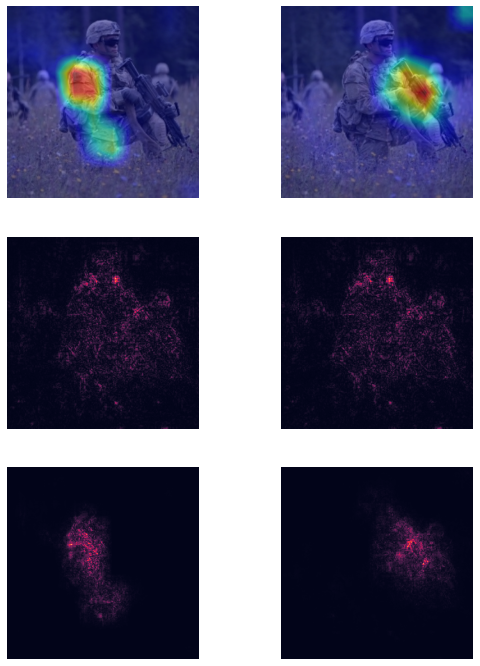

In [ ]:
#@title

utils.plt.figure(figsize=(9, 12))
utils.plot_heatmaps(to_image([images[7], images[7]]),
                    maps[..., 0].numpy(),
                    rows=3, cols=2, full=False)
utils.plot(gs[..., 0].numpy(), rows=3, cols=2, full=False, i0=2)
utils.plot(gm[..., 0].numpy(), rows=3, cols=2, full=False, i0=4)

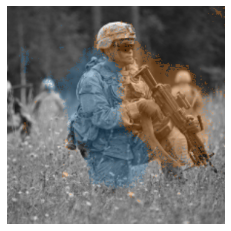

In [ ]:
BG_PAD = [[1, 0], [0, 0], [0, 0], [0, 0]]
gmb = tf.pad(gm, BG_PAD, 'CONSTANT', .01)

seg = tf.argmax(gmb, axis=0)[..., 0]
plot_segmentation_maps(images[7], seg)

In [ ]:
SAMPLES = [x[11], x[11]]

POSITIVE = tf.constant([[282, 285, 281],
                        [260, 207, 208]])
NEGATIVE = tf.constant([[260, 207, 208],
                        [282, 285, 281]])

SEGMENTS = ['cat', 'dog']

# One image at a time to avoid performance issues with larger models.
r = [smooth_gradients(SAMPLES[i:i+1],
                      POSITIVE[i:i+1],
                      NEGATIVE[i:i+1],
                      REPETITIONS,
                      NOISE)
     for i in range(len(SAMPLES))]

loss, grads, maps = (tf.concat(t, axis=0) for t in zip(*r))

# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

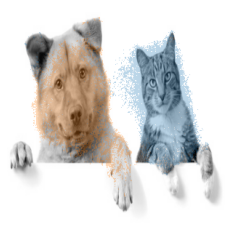

In [ ]:
BG_PAD = [[1, 0], [0, 0], [0, 0], [0, 0]]
gmb = tf.pad(gm, BG_PAD, 'CONSTANT', .01)

seg = tf.argmax(gmb, axis=0)[..., 0]
plot_segmentation_maps(images[11], seg)

## FullGrad Backpropagation

In [ ]:
def extract_bias(layer):
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        # Batch norm := ((x - m)/s)*w + b
        # Hence bias factor is -m*w/s + b.
        return (
            -layer.moving_mean * layer.gamma
            / tf.sqrt(layer.moving_variance + 1e-07)  # might be variance here.
            + layer.beta)

    if hasattr(layer, 'bias') and layer.bias is not None:
        return layer.bias

def psi(x):
    x = tf.abs(x)
    x = standardize(x)

    return x

In [ ]:
layers = [(l, extract_bias(l)) for ix, l in enumerate(nn.layers[1:-1])]
layers = [(l, b) for l, b in layers if b is not None]

intermediates = [l.output for l, _ in layers]
biases = [b for _, b in layers]

print(len(biases), 'layers with bias were found.')

nn_s = tf.keras.Model(nn.inputs,
                      outputs=[nn.output, nn.get_layer(LAST_SPACIAL_LAYER).output, *intermediates],
                      name='spacial_model')

130 layers with bias were found.


In [ ]:
def reduce_noise(x, num_samples):
    x = tf.reshape(x, (-1, num_samples, *x.shape[1:]))
    x = tf.reduce_mean(x, axis=1)
    return x

@tf.function
def gradients(inputs, positive, negative):
    with tf.GradientTape() as tapeP:
        tape.watch(inputs)
        y, s, *ia = nn_s(inputs, training=False)
        loss = min_max_activation_gain(y, positive, negative)
    
    dydx, dyds, *ig = tape.gradient(loss, [inputs, s, *ia])

    return loss, s, dydx, dyds, ig

def gradcam(s, dyds):
    weights = tf.reduce_mean(dyds, axis=(1, 2), keepdims=True)
    maps = tf.reduce_mean(s*weights, axis=-1, keepdims=True)

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)
    return maps

@tf.function
def smooth_fullgradients(inputs, positive, negative, num_samples=50, noise=.2):
    print('tracing smooth-fullgradients', positive, negative)

    x = tf.repeat(inputs, num_samples, axis=0)
    x += tf.random.normal(tf.shape(x), mean=127.5, stddev=noise/2)

    positive = tf.repeat(positive, num_samples, axis=0)
    negative = tf.repeat(negative, num_samples, axis=0)

    loss, s, dydx, dyds, dydas = gradients(x, positive, negative)

    cams = gradcam(s, dyds)

    fx = dydx * inputs
    fx = reduce_noise(fx, num_samples)
    maps = tf.reduce_sum(psi(fx), axis=-1, keepdims=True)

    Gb = [ig * tf.reshape(b, (1, 1, 1, -1)) for ig, b in zip(dydas, biases)]
    for b in Gb:
        b = reduce_noise(b, num_samples)
        b = psi(b)
        maps += tf.reduce_sum(tf.image.resize(b, config.data.image_size), axis=-1, keepdims=True)
    
    return (reduce_noise(loss, num_samples),
            reduce_noise(dydx, num_samples),
            reduce_noise(cams, num_samples),
            maps)

In [ ]:
SAMPLES = [x[7], x[7]]

POSITIVE = tf.constant([[652, 465],
                        [413, 764]])
NEGATIVE = tf.constant([[413, 764],
                        [652, 465]])

SEGMENTS = ['military_uniform', 'assault_rifle']

# One image at a time to avoid performance issues with larger models.
r = [smooth_fullgradients(SAMPLES[i:i+1],
                          POSITIVE[i:i+1],
                          NEGATIVE[i:i+1],
                          REPETITIONS,
                          NOISE)
     for i in range(len(SAMPLES))]

loss, grads, cams, maps = (tf.concat(t, axis=0) for t in zip(*r))

# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)
maps = normalize(maps)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

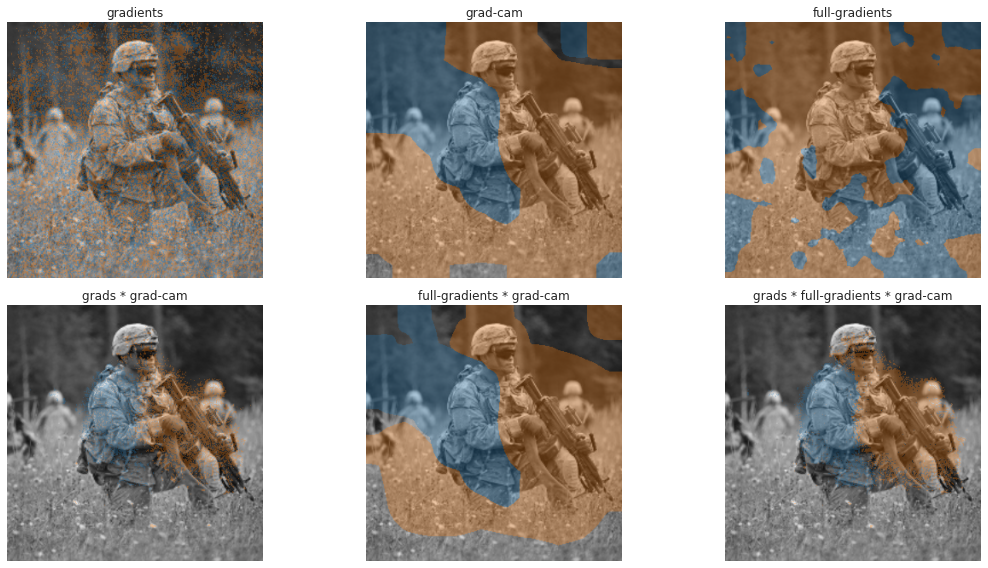

In [ ]:
segs = [gs, cams, maps, gs * cams, maps * cams, gm * cams]

def to_segmentation(x, bg_t=0.01):
    y = tf.pad(x, BG_PAD, 'CONSTANT', bg_t)  # Add background index 0
    y = tf.argmax(y, axis=0)[..., 0]        # Infer class-per-pixel
    return y

def imseg(i, seg):
    return color.label2rgb(seg.numpy(), to_image(i), bg_label=0, bg_color=None, colors=C)

utils.plot([imseg(images[7], to_segmentation(s)) for s in segs],
           titles=['gradients', 'grad-cam', 'full-gradients',
                   'grads * grad-cam', 'full-gradients * grad-cam', 'grads * full-gradients * grad-cam'],
           rows=2)

In [ ]:
SAMPLES = tf.repeat(x[11:12], 2, axis=0)

POSITIVE = tf.constant([[282, 285, 281],
                        [260, 207, 208]])
NEGATIVE = tf.constant([[260, 207, 208],
                        [282, 285, 281]])

SEGMENTS = ['cat', 'dog']

# One image at a time to avoid performance issues with larger models.
r = [smooth_fullgradients(SAMPLES[i:i+1],
                          POSITIVE[i:i+1],
                          NEGATIVE[i:i+1],
                          REPETITIONS,
                          NOISE)
     for i in range(len(SAMPLES))]

loss, grads, cams, maps = (tf.concat(t, axis=0) for t in zip(*r))

# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)
maps = normalize(maps)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

tracing smooth-fullgradients Tensor("positive:0", shape=(1, 3), dtype=int32) Tensor("negative:0", shape=(1, 3), dtype=int32)


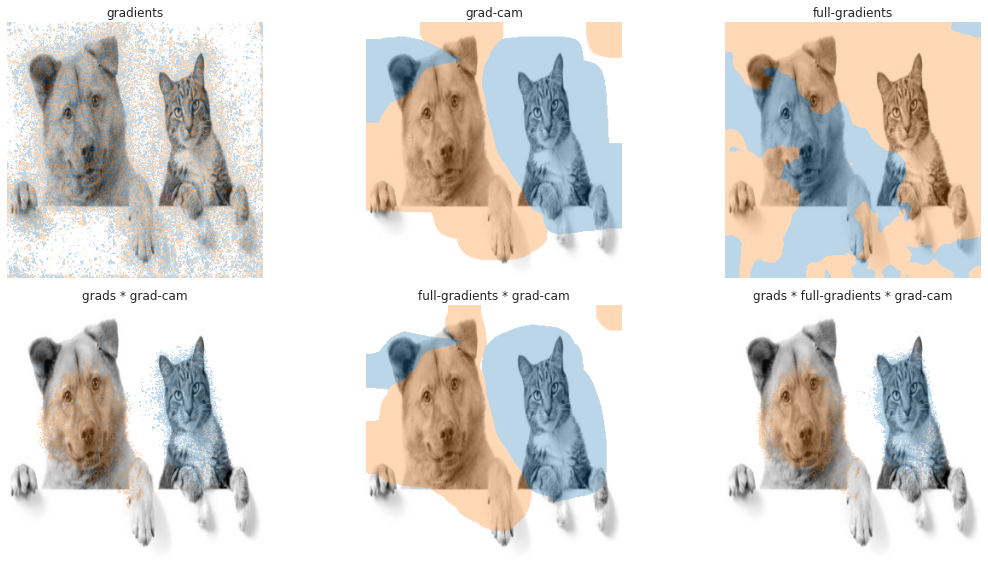

In [ ]:
segs = [gs, cams, maps, gs * cams, maps * cams, gm * cams]

utils.plot([imseg(images[11], to_segmentation(s)) for s in segs],
           titles=['gradients', 'grad-cam', 'full-gradients',
                   'grads * grad-cam', 'full-gradients * grad-cam', 'grads * full-gradients * grad-cam'],
           rows=2)

In [ ]:
SAMPLES = tf.repeat(x[12:13], 4, axis=0)

POSITIVE = tf.constant([[281], [282], [285], [283]])
NEGATIVE = tf.zeros((4, 0), dtype=tf.int32)

# One image at a time to avoid performance issues with larger models.
r = [smooth_fullgradients(SAMPLES[i:i+1],
                          POSITIVE[i:i+1],
                          NEGATIVE[i:i+1],
                          REPETITIONS,
                          NOISE)
     for i in range(len(SAMPLES))]

loss, grads, cams, maps = (tf.concat(t, axis=0) for t in zip(*r))

# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)
maps = normalize(cams)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

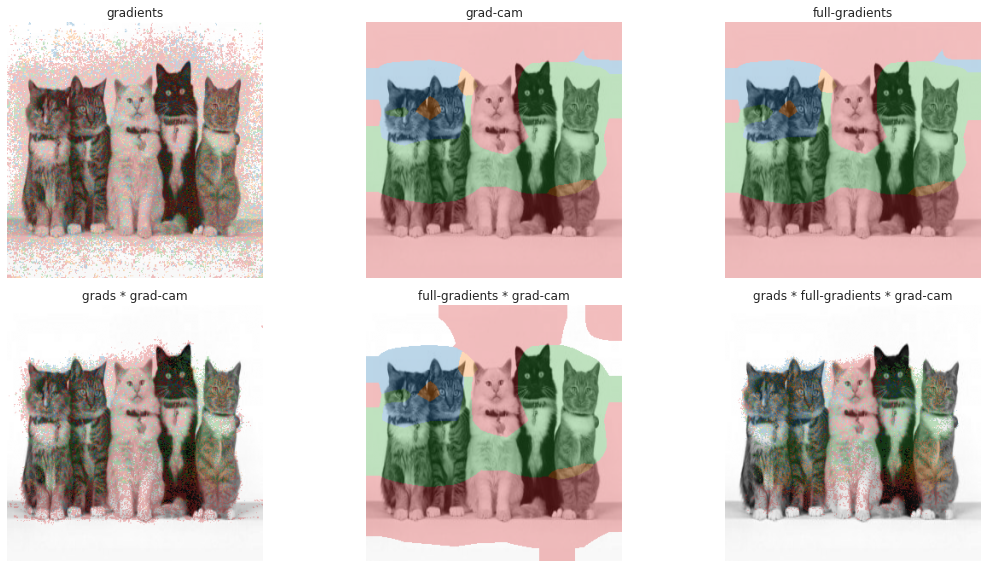

In [ ]:
segs = [gs, cams, maps, gs * cams, maps * cams, gm * cams]

utils.plot([imseg(images[12], to_segmentation(s)) for s in segs],
           titles=['gradients', 'grad-cam', 'full-gradients',
                   'grads * grad-cam', 'full-gradients * grad-cam', 'grads * full-gradients * grad-cam'],
           rows=2)